In [1]:
%matplotlib inline

import unyt
import numpy as np
import matplotlib.pyplot as plt

from cool_func_stats import find_special_locations_isobar
from cholla_cooling import ChollaEOS

In [2]:
cholla_cie_eos = ChollaEOS()
cholla_cloudy_eos = ChollaEOS(
    cloudy_data_path = ('/home/mabruzzo/hydro/cholla/src/cooling/'
                        'cloudy_coolingcurve.txt')
)

def load_grackle_eos():
    from gascloudtool.eos import GrackleEOS
    return GrackleEOS.build_default_eos()

/home/mabruzzo/packages/py3/gascloudutil/gascloudutil/cholla_cooling.py:118: RuntimeWarning: divide by zero encountered in true_divide
  return eint_dens / cool
/home/mabruzzo/packages/py3/gascloudutil/gascloudutil/cholla_cooling.py:118: RuntimeWarning: divide by zero encountered in true_divide
  return eint_dens / cool
/home/mabruzzo/packages/py3/gascloudutil/gascloudutil/cholla_cooling.py:118: RuntimeWarning: divide by zero encountered in true_divide
  return eint_dens / cool
/home/mabruzzo/packages/py3/gascloudutil/gascloudutil/cholla_cooling.py:118: RuntimeWarning: divide by zero encountered in true_divide
  return eint_dens / cool


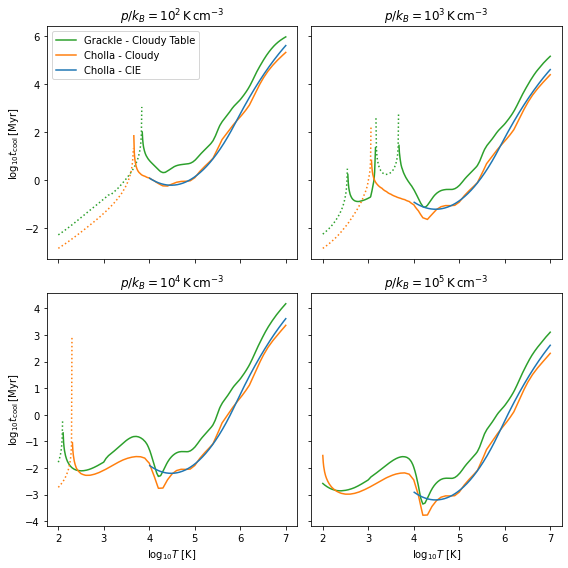

In [3]:
def _plot_tcool(ax, T_vals, cool_val, label = None, color = None):
    log_cool_val = np.empty_like(cool_val)
    w = cool_val < 0
    log_cool_val[w] = np.log10(-1*cool_val[w])
    log_cool_val[~w] = np.inf

    kw = {}
    if label is not None:
        kw['label'] = label
    if color is not None:
        kw['color'] = color
    ax.plot(np.log10(T_vals), log_cool_val, **kw)
    log_heat_val = np.empty_like(cool_val)
    w = cool_val > 0
    log_heat_val[w] = np.log10(cool_val[w])
    log_heat_val[~w] = np.inf
    kw = {}
    if color is not None:
        kw['color'] = color
    ax.plot(np.log10(T_vals), log_heat_val, ls = ':', **kw)

def plot_tcool(ax, eos, T_min, T_max, pressure, num = 501,
               color = None, label = None):
    assert T_min < T_max
    
    n_min = pressure / (unyt.kboltz_cgs.v * T_min)
    n_max = pressure / (unyt.kboltz_cgs.v * T_max)
    
    if isinstance(eos, ChollaEOS): # drop the units!
        pressure = pressure.in_cgs().v
        T_min, T_max = T_min.in_cgs().v, T_max.in_cgs().v
        n_min, n_max = n_min.in_cgs().v, n_max.in_cgs().v

    # we are bending over backwards here to do this calculation
    # in terms of specific internal energy so we can make
    # comparisons with Grackle
    _, eint_min = eos.rho_eint_from_nT(n_min, T_min)
    _, eint_max = eos.rho_eint_from_nT(n_max, T_max)

    eint_vals = np.geomspace(eint_min, eint_max, num = num)
    if not isinstance(eos, ChollaEOS): # preserve the units
        eint_vals = unyt.unyt_array(eint_vals, eint_min.units)
    inv_gm1 = 1.0 / (eos.get_gamma() - 1.0)
    rho_vals = pressure * inv_gm1 / eint_vals

    T_vals = eos.calculate_T(rho_vals, eint_vals)
    
    
    tcool = unyt.unyt_array(eos.calculate_tcool(rho_vals, eint_vals), 's')
    
    _plot_tcool(ax, T_vals, tcool.to('Myr').v, label = label, color = color)

fig,ax_arr = plt.subplots(2,2, figsize = (8,8), sharex = True, sharey = 'row')

for ax, phat_power in zip(ax_arr.flatten(), [2,3,4,5]):
    kwargs = dict(T_min = 1e2 * unyt.K, T_max = 1e7 * unyt.K, num = 501,
                  pressure = unyt.unyt_quantity(10.0**phat_power,'K/cm**3') * unyt.kboltz_cgs,)
    if True:
        plot_tcool(ax, load_grackle_eos(),
                   color = 'C2', label = 'Grackle - Cloudy Table',
                   **kwargs)

    plot_tcool(ax, eos = cholla_cloudy_eos,
               color = 'C1', label = 'Cholla - Cloudy',
               **kwargs)

    plot_tcool(ax, eos = cholla_cie_eos,
                color = 'C0', label = 'Cholla - CIE',
               **kwargs)
    

    ax.set_title(r'$p/k_B = 10^{' + str(phat_power) + r'}\, {\rm K}\, {\rm cm}^{-3}$')

for i in range(2):
    ax_arr[1,i].set_xlabel(r'$\log_{10} T$ [K]');
    ax_arr[i,0].set_ylabel(r'$\log_{10} t_{\rm cool}\, $[Myr]')

ax_arr[0,0].legend()
fig.tight_layout()

In [4]:
def _find_loc_mintcool(eos, Tmin, Tmax, 
                       pressure = unyt.unyt_quantity(1e3,'K/cm**3')* unyt.kboltz_cgs):
    # find the location in phase-space where tcool is minimized at a given
    # pressure (between Tmin and Tmax)
    #
    # At the moment, this will only work with Cholla's CIE cooling curve!
    
    if (not isinstance(eos, ChollaEOS)) or (not eos.using_CIE_cooling()):
        raise RuntimeError("At the moment, this function is not general "
                           "purpose enough to work with anything other "
                           "than Cholla's CIE cooling curve")

    # strip off units (if applicable)
    if isinstance(Tmin, unyt.unyt_quantity): Tmin = Tmin.to('K').v  
    if isinstance(Tmax, unyt.unyt_quantity): Tmax = Tmax.to('K').v
    if isinstance(pressure, unyt.unyt_quantity): pressure = pressure.in_cgs().v

    _, specific_eint_min = eos.rho_eint_from_nT(
        pressure/(Tmin*unyt.kboltz_cgs.v), Tmin)
    _, specific_eint_max = eos.rho_eint_from_nT(
        pressure/(Tmax*unyt.kboltz_cgs.v), Tmax)

    log_specific_eint_step = 0.1

    gm1 = (eos.get_gamma() - 1)
    special_eint_vals, is_thermal_eq = find_special_locations_isobar(
        pthermal_div_gm1 = pressure / gm1,
        specific_eint_bounds = [specific_eint_min, specific_eint_max],
        brute_step = log_specific_eint_step,
        is_log10_brute_step = True,
        cooling_eos = eos,
        maxiter_each = 500, s_rel_tol = 1e-8,
        skip_unstable_equilibrium = False)
    
    special_rho_vals = pressure / gm1 / special_eint_vals
    special_tcool = eos.calculate_tcool(rho = special_rho_vals,
                                        eint = special_eint_vals)
    
    # sanity-checks!
    assert special_eint_vals.size == 3
    # confirm that all of special values are related to cooling (not heating!)
    assert np.all(special_tcool < 0.0).all()
    assert np.all(np.logical_not(is_thermal_eq)) # no thermodynamic equilibrium
    
    special_T = eos.calculate_T(rho = special_rho_vals,
                                eint = special_eint_vals)

    min_index = np.argmin(np.abs(special_tcool))
    print(f"The minimum cooling time between {Tmin} K and {Tmax} K, at "
          f"pressure/kboltz = {pressure / unyt.kboltz_cgs.v!r} is:\n"
          f"     |tcool| = {special_tcool[min_index]}\n"
          f"     it occurs at T = {special_T[min_index]} K or equivalently\n"
          f"     at eint = {special_eint_vals[min_index]} cm**2/s**2")
    return special_eint_vals[min_index], special_T[min_index], special_tcool[min_index]
_find_loc_mintcool(eos = cholla_cie_eos, Tmin = 1e4, Tmax = 1e7)

The minimum cooling time between 10000.0 K and 10000000.0 K, at pressure/kboltz = 999.9999999999998 is:
     |tcool| = -1981296614494.0332
     it occurs at T = 30253.05541192792 K or equivalently
     at eint = 6243060742194.229 cm**2/s**2


(6243060742194.229, 30253.05541192792, -1981296614494.0332)

In [5]:
def find_tcool_minmix(Tcl, Tw, vwind, assumed_p,
                      eos = cholla_cie_eos):
    """
    Calculate tcool_minmix at the given pressure.
    
    This assumes that cloud will not cool below Tcl
    
    Parameters
    ----------
    Tcl : unyt.unyt_quantity
        The cloud temperature
    Tw : unyt.unyt_quantity
        The wind temperature
    assumed_p : unyt.unyt_quantity
        The assumed pressure. This assumes things are at
        constant pressure.
    valid_coolingcurve_Trange : seq of 2 unyt.unyt_quantities
        The range temperatures where cooling is valid.
    eos : equation of state
    """
    
    if (not isinstance(eos, ChollaEOS)) or (not eos.using_CIE_cooling()):
        raise RuntimeError("At the moment, this function is not general "
                           "purpose enough to work with anything other "
                           "than Cholla's CIE cooling curve")
    else:
        valid_coolingcurve_Trange = np.array([1e4, 1e12]) * unyt.K

    Tcl = Tcl.to('K')
    Tw = Tw.to('K')
    assert valid_coolingcurve_Trange[0] <= Tcl <= valid_coolingcurve_Trange[1]
    assert valid_coolingcurve_Trange[0] <= Tw <= valid_coolingcurve_Trange[1]

    # find the specific internal energy & temperature where cooling is minimized along the isobar
    e_mincool, T_mincool = _find_loc_mintcool(
        eos, Tmin = valid_coolingcurve_Trange[0],
        Tmax = valid_coolingcurve_Trange[1], pressure = assumed_p.to('dyne/cm**2'))
    
    
    special_rho_vals = pressure / gm1 / special_eint_vals

    e_w = np.sqrt(e_mincool * e_w)
    _, e_wind = eos.rho_eint_from_nT(
        (assumed_p.to('dyne/cm**2')/(Tw*unyt.kboltz_cgs)).to('cm**-3'),
        Tw.to('K').v)
    
    e_mincool = e_mincool * unyt.cm**2/unyt.s**2

    e_minmix = np.sqrt(e_mincool * e_w)
    rho_minmix = (assumed_p / (eos.get_gamma() - 1) * e_minmix).to('g/cm**3')
    
    tcool_minmix = eos.calculate_T(rho = special_rho_vals.v,
                                   eint = e_minmix.v)

    return tcool_minmix
